In [ ]:
# Suppression des avertissements
import warnings
warnings.filterwarnings('ignore')

# Modules de base
import numpy as np
import pandas as pd
import random

# Visualisation
import matplotlib.pyplot as plt
import seaborn as sns

# Stats et analyses statistiques
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.preprocessing import StandardScaler

# Machine Learning et modèles de régression
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Divers
import joblib

# Configuration du style de visualisation des graphiques avec un style personnalisé
plt.style.use("https://github.com/dhaitz/matplotlib-stylesheets/raw/master/pitayasmoothie-dark.mplstyle")
# Configuration pour l'affichage des nombres à virgule flottante
pd.options.display.float_format = '{:.4f}'.format

In [2]:
# Chargement des modèles
model_lr = joblib.load('../00 - Annexes/models/model_lr.pkl')
model_rf = joblib.load('../00 - Annexes/models/model_rf.pkl')
model_xgb = joblib.load('../00 - Annexes/models/model_xgb.pkl')
model_ridge = joblib.load('../00 - Annexes/models/model_ridge.pkl')
model_lasso = joblib.load('../00 - Annexes/models/model_lasso.pkl')
model_dt = joblib.load('../00 - Annexes/models/model_dt.pkl')
model_sarimax = joblib.load('../00 - Annexes/models/model_sarimax.pkl')

--------------------------------------


In [3]:
# Chargement du jeu de validation scalé
df_validation_scaled = pd.read_csv("../00 - Annexes/data_prepro/donnees_validation_scaled.csv")

metrics_train = pd.read_csv('../00 - Annexes/data_prepro/metrics_train.csv')

In [4]:
# Extraire les identifiants et la cible
df_predictions = df_validation_scaled[['SKU', 'Prix']].copy()

# Préparer les features pour les modèles ML
X_validation_scaled = df_validation_scaled.drop(columns=['SKU', 'Prix', 'Timestamp']).values

# Prédictions des modèles de régression
df_predictions['Régression Linéaire'] = model_lr.predict(X_validation_scaled)
df_predictions['Random Forest']= model_rf.predict(X_validation_scaled)
df_predictions['XGBoost'] = model_xgb.predict(X_validation_scaled)
df_predictions['Ridge'] = model_ridge.predict(X_validation_scaled)
df_predictions['Lasso']= model_lasso.predict(X_validation_scaled)
df_predictions['Decision Tree']= model_dt.predict(X_validation_scaled)

# Préparer les exogènes pour SARIMAX
exog_columns = ['QuantiteVendue', 'UtiliteProduit', 'ElasticitePrix', 'Remise']
exog_validation = df_validation_scaled[exog_columns]

# Nettoyage des exogènes
exog_validation.replace([np.inf, -np.inf], np.nan, inplace=True)
exog_validation.dropna(inplace=True)

# Vérifier les dimensions des exogènes avant prédiction
if len(exog_validation) != len(df_predictions):
    raise ValueError("Mismatch between exogenous variables and target size!")

# Faire les prédictions SARIMAX
forecast = model_sarimax.get_forecast(steps=len(exog_validation), exog=exog_validation)
df_predictions['SARIMAX'] = forecast.predicted_mean.values

df_predictions


,SKU,Prix,Régression Linéaire,Random Forest,XGBoost,Ridge,Lasso,Decision Tree,SARIMAX
0,SKU1_1,422.9680,374.2910,325.3685,431.3333,374.2890,374.2111,403.2484,96.5402
1,SKU1_1,422.8309,377.2399,325.2340,431.3676,377.2379,377.1638,403.2484,96.4163
2,SKU1_1,422.4601,375.5006,326.3964,431.2112,375.4986,375.4520,403.2484,96.2747
3,SKU1_1,380.1274,353.2920,301.3767,395.0385,353.2898,353.2696,376.8968,-164.1719
4,SKU1_1,423.2454,380.4108,325.2916,431.1252,380.4089,380.3295,403.2484,96.0236
...,...,...,...,...,...,...,...,...,...
27370,SKU3_8,39.8088,53.5148,39.6807,39.0476,53.5157,53.4998,36.3610,-1.0039
27371,SKU3_8,40.2398,52.5392,39.6686,39.0450,52.5400,52.5505,36.3610,-0.9873
27372,SKU3_8,40.1021,51.2325,39.3304,39.0505,51.2334,51.2124,36.3610,-0.9574
27373,SKU3_8,39.5782,56.0025,39.4342,39.0476,56.0034,55.9833,36.3610,-1.0441


In [5]:
# Calcul des métriques pour chaque modèle
metrics = {}
for model_name in ['Régression Linéaire', 'Random Forest', 'XGBoost', 
        'Ridge', 'Lasso', 'Decision Tree', 'SARIMAX']:
    mse = mean_squared_error(df_predictions['Prix'], df_predictions[model_name])
    mae = mean_absolute_error(df_predictions['Prix'], df_predictions[model_name])
    rmse = mse ** 0.5
    r2 = r2_score(df_predictions['Prix'], df_predictions[model_name])
    metrics[model_name] = {'RMSE': rmse, 'MAE': mae, 'R² Score': r2}

# Calcul des métriques pour SARIMAX
mse_sarimax = mean_squared_error(df_predictions['Prix'], df_predictions['SARIMAX'])
mae_sarimax = mean_absolute_error(df_predictions['Prix'], df_predictions['SARIMAX'])
rmse_sarimax = mse_sarimax ** 0.5

# Ajouter SARIMAX aux métriques
metrics['SARIMAX'] = {'RMSE': rmse_sarimax, 'MAE': mae_sarimax, 'R² Score': None}

# Convertir les métriques en DataFrame
metrics_val = pd.DataFrame(metrics).T.reset_index().rename(columns={'index': 'Modèle'})
metrics_val

,Modèle,RMSE,MAE,R² Score
0,Régression Linéaire,20.4395,16.5832,0.9823
1,Random Forest,40.5164,22.5902,0.9306
2,XGBoost,6.2265,3.9407,0.9984
3,Ridge,20.4400,16.5835,0.9823
4,Lasso,20.4461,16.5849,0.9823
5,Decision Tree,9.6900,5.4117,0.9960
6,SARIMAX,274.8427,215.4589,NaN


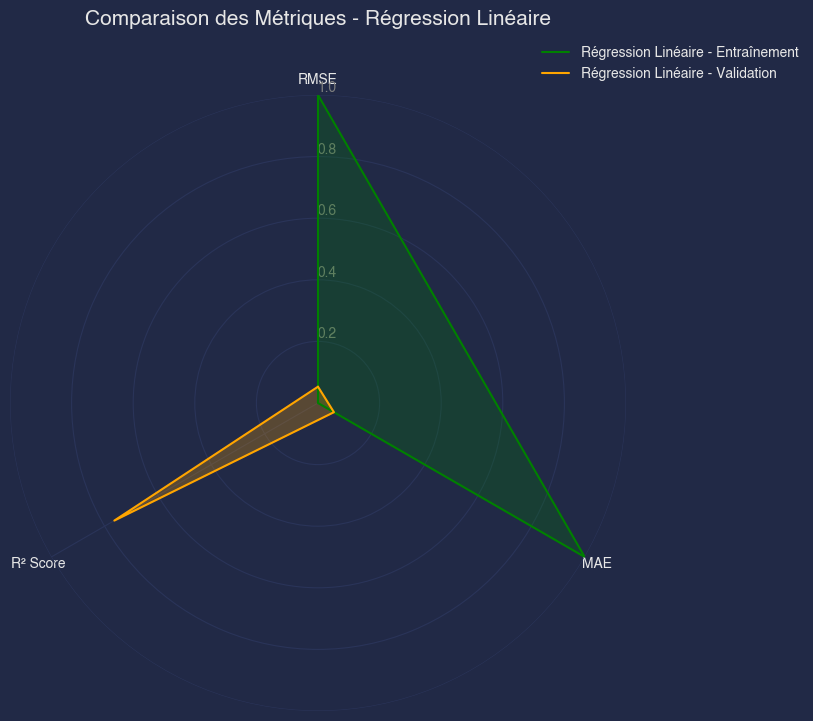

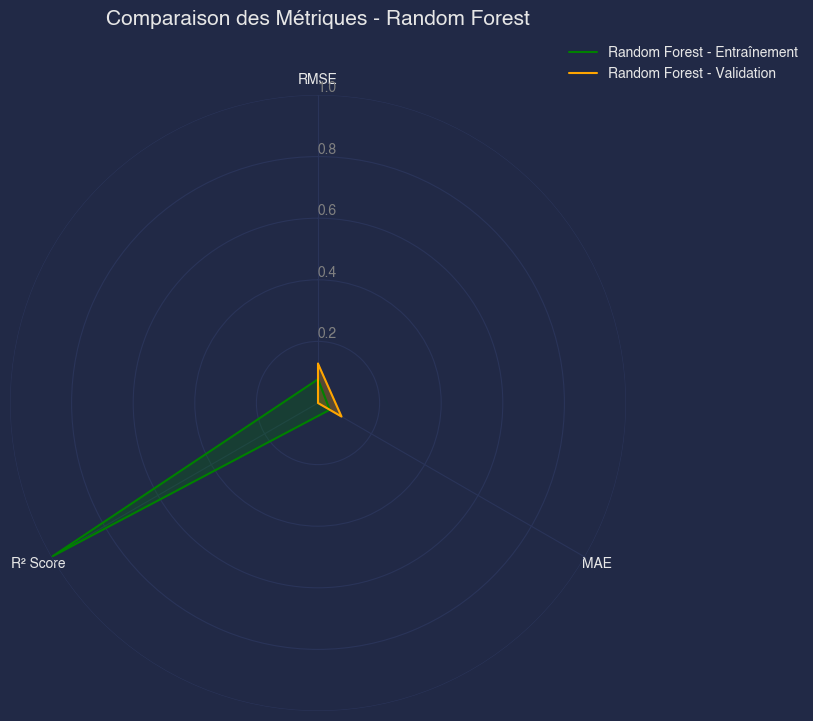

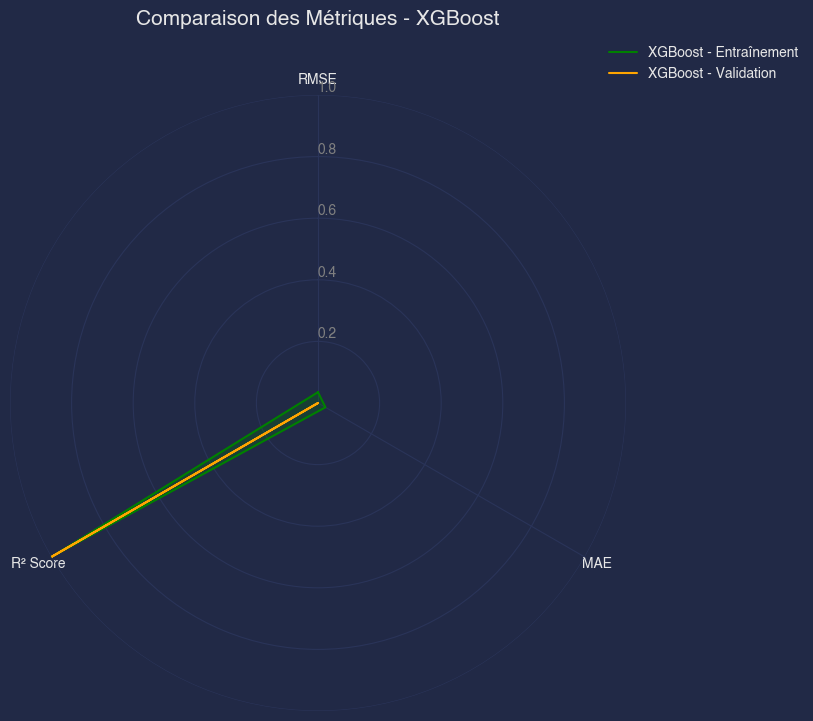

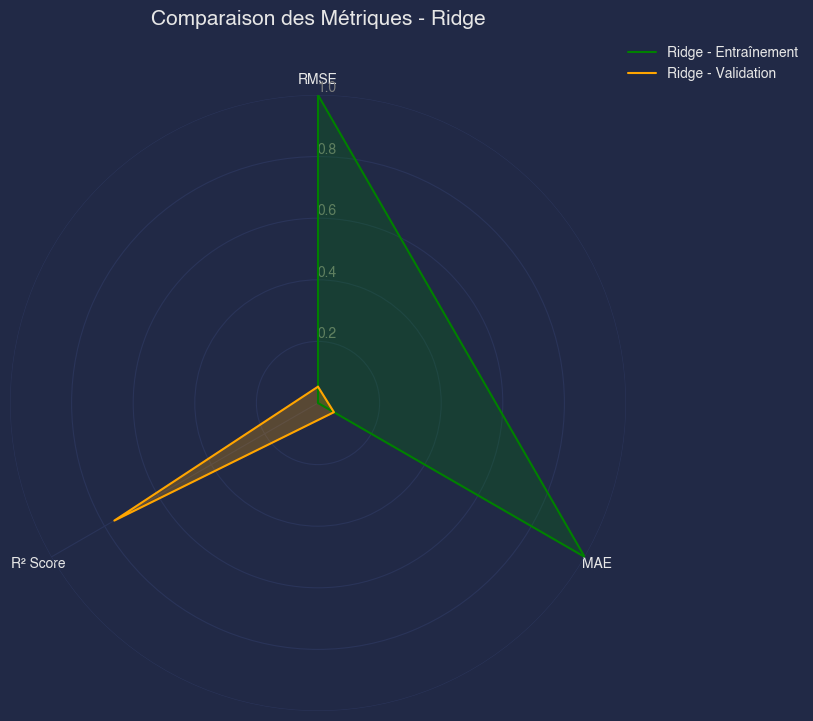

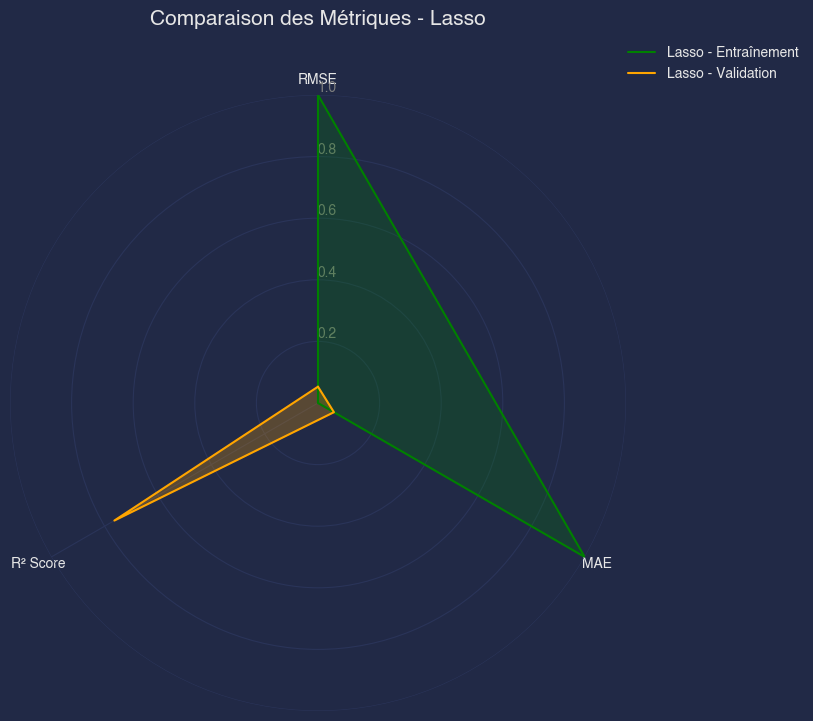

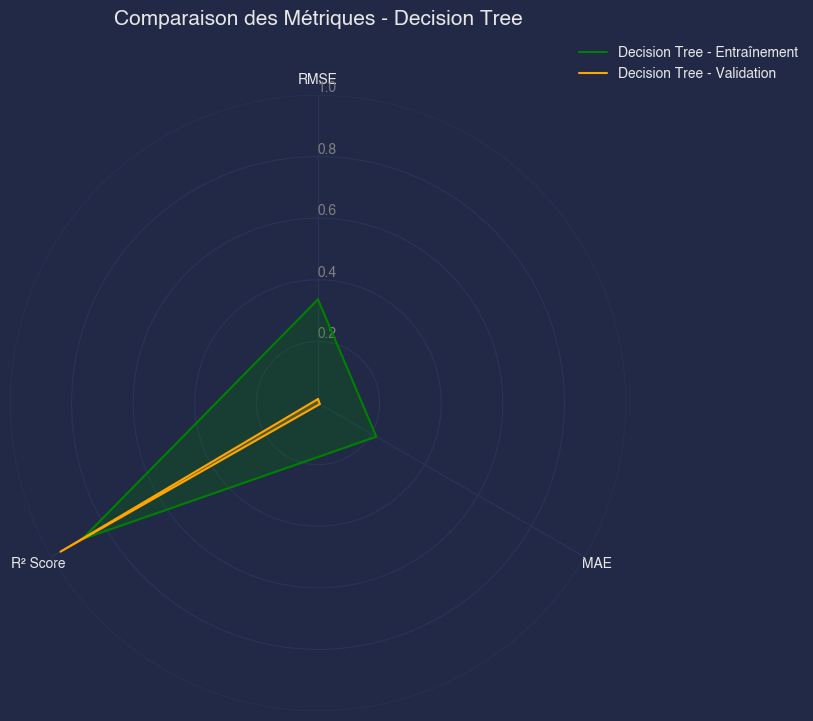

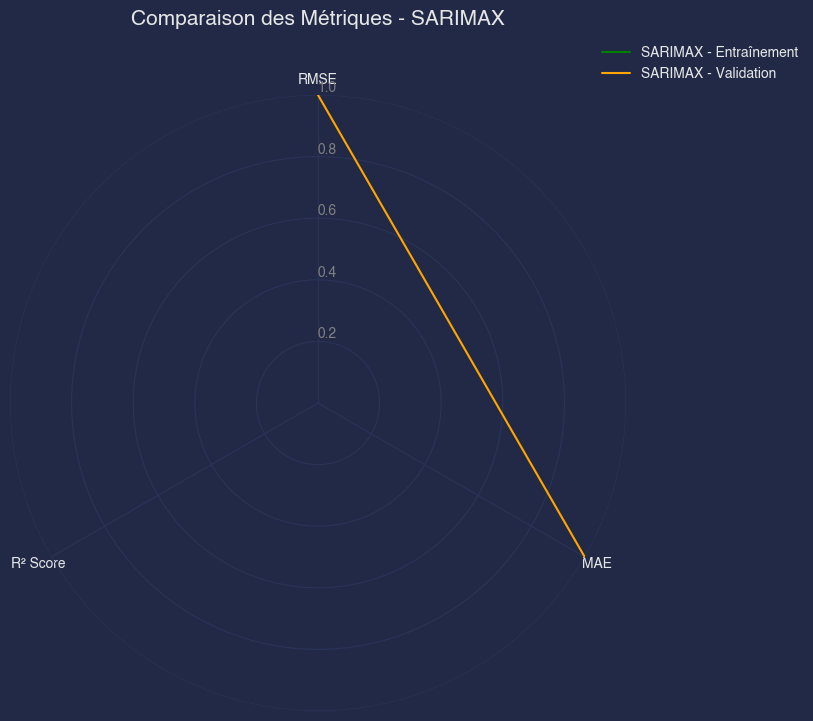

In [6]:
# Fonction pour normaliser les métriques entre 0 et 1
def normalize_metrics(metrics_df):
    metrics_normalized = metrics_df.copy()
    # Normalisation des colonnes numériques
    metrics_normalized.iloc[:, 1:] = metrics_df.iloc[:, 1:].apply(lambda x: (x - x.min()) / (x.max() - x.min()))
    return metrics_normalized

# Normaliser les métriques d'entraînement et de validation
metrics_train_normalized = normalize_metrics(metrics_train)
metrics_val_normalized = normalize_metrics(metrics_val)

# Fonction pour tracer un graphique radar pour un modèle spécifique
def plot_radar(metrics_train, metrics_val, model_name):
    # Configurer les index pour aligner les métriques
    metrics_train = metrics_train.set_index("Modèle")
    metrics_val = metrics_val.set_index("Modèle")
    
    # Extraire les métriques du modèle
    train_metrics = metrics_train.loc[model_name].values
    val_metrics = metrics_val.loc[model_name].values
    
    # Définir les catégories (colonnes)
    categories = metrics_train.columns
    num_vars = len(categories)
    
    # Préparer les angles pour le radar
    angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
    angles += angles[:1]  # Fermer le cercle
    
    # Fermer le cercle pour les données
    train_metrics = np.append(train_metrics, train_metrics[0])
    val_metrics = np.append(val_metrics, val_metrics[0])
    
    # Création du graphique radar
    fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))
    
    # Tracer les métriques d'entraînement
    ax.plot(angles, train_metrics, label=f'{model_name} - Entraînement', color='green')
    ax.fill(angles, train_metrics, alpha=0.25, color='green')
    
    # Tracer les métriques de validation
    ax.plot(angles, val_metrics, label=f'{model_name} - Validation', color='orange')
    ax.fill(angles, val_metrics, alpha=0.25, color='orange')
    
    # Configuration des labels et de l'affichage
    ax.set_theta_offset(np.pi / 2)
    ax.set_theta_direction(-1)
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(categories)
    ax.set_rlabel_position(0)
    ax.set_yticks([0.2, 0.4, 0.6, 0.8, 1.0])
    ax.set_yticklabels(["0.2", "0.4", "0.6", "0.8", "1.0"], color="grey", size=10)
    ax.set_ylim(0, 1)
    
    # Ajouter légende et titre
    plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))
    plt.title(f'Comparaison des Métriques - {model_name}', size=15, y=1.1)
    plt.show()

# Tracer les graphiques radar pour chaque modèle
for model_name in metrics_train_normalized['Modèle']:
    plot_radar(metrics_train_normalized, metrics_val_normalized, model_name)


-----------------------------------------


Prédictions pour le SKU : SKU2_3 au timestamp : 2023-06-12 16:00:00
                Modèle    Prix
0            Prix Réel 21.4929
1  Régression Linéaire 23.9397
2      Forêt Aléatoire 21.7198
3              XGBoost 21.6723
4     Régression Ridge 23.9398
5     Régression Lasso 23.9479
6    Arbre de Décision 21.4441
7       Moyenne Mobile 21.0932


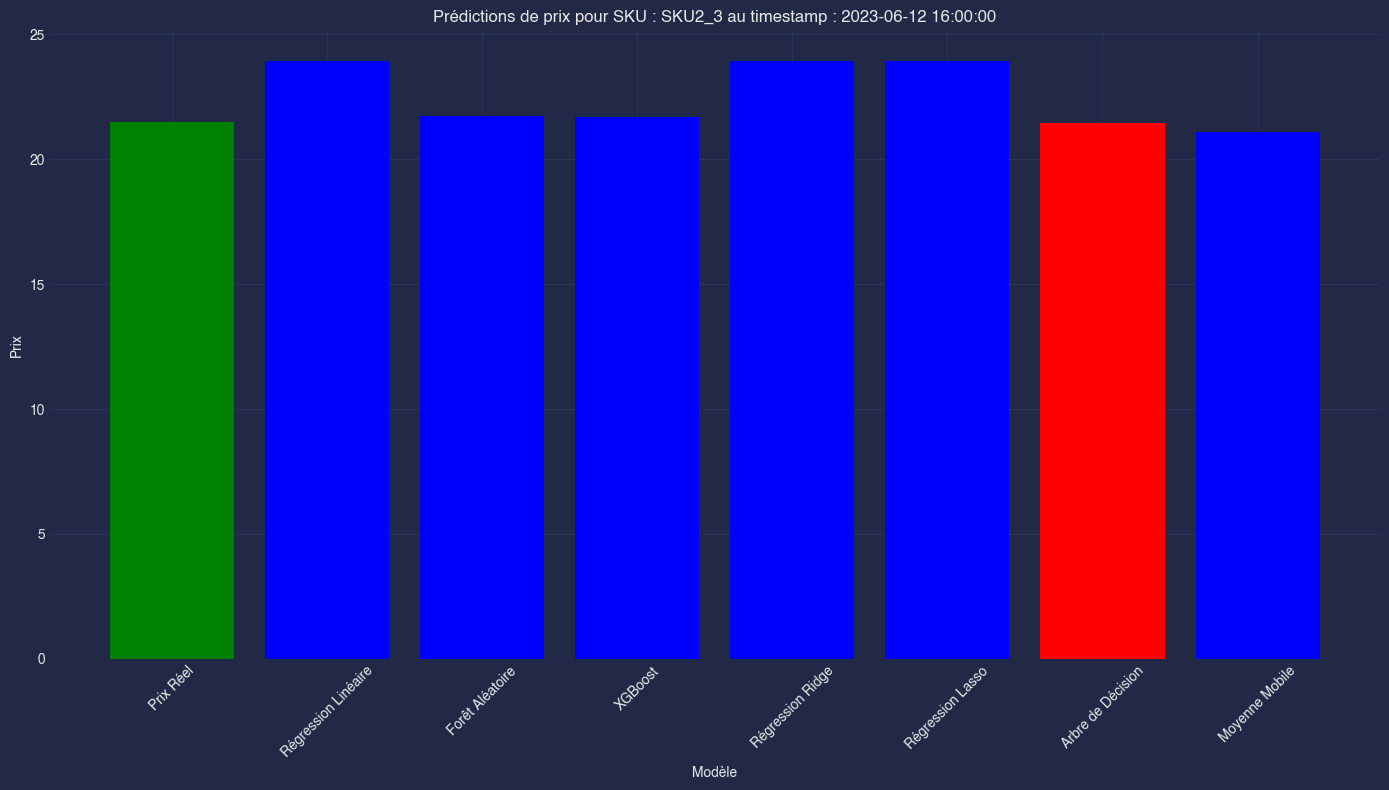

In [7]:


# Calcul de la moyenne mobile avant transformation
window_size = 9
df_validation_scaled['Moving_Avg'] = df_validation_scaled['Prix'].rolling(window=window_size, min_periods=1).mean()

# Sélection d'une observation aléatoire
random_index = random.randint(0, len(df_validation_scaled) - 1)
random_observation = df_validation_scaled.iloc[random_index]
random_sku = random_observation['SKU']
random_timestamp = random_observation['Timestamp']

# Recherche de l'index
df_random_index = df_validation_scaled[
    (df_validation_scaled['SKU'] == random_sku) &
    (df_validation_scaled['Timestamp'] == random_timestamp)
].index

if len(df_random_index) != 1:
    raise ValueError("L'observation sélectionnée n'est pas unique.")

index_random = df_random_index[0]

# Prix réel (normalisé)
y_actual = df_validation_scaled.loc[index_random, 'Prix']

# Prix réel dénormalisé

# Moyenne mobile avant transformation
y_pred_moving_avg = df_validation_scaled.loc[index_random, 'Moving_Avg']

# Préparation des données pour les modèles non-SARIMAX
df_random_reg = df_validation_scaled.loc[[index_random]].copy()

# Suppression des colonnes non nécessaires
exclude_columns = ['Prix', 'SKU', 'Timestamp', 'Moving_Avg']
df_random_reg = df_random_reg.drop(columns=exclude_columns, errors='ignore')

# Sélection des colonnes d'entraînement
training_columns = df_validation_scaled.drop(columns=exclude_columns, errors='ignore').columns

# Ajout des colonnes manquantes pour l'alignement
missing_cols = set(training_columns) - set(df_random_reg.columns)
for col in missing_cols:
    df_random_reg[col] = 0

# Alignement des colonnes
df_random_reg = df_random_reg[training_columns]

# Prédictions avec les modèles hors SARIMAX
y_pred_lr = model_lr.predict(df_random_reg)[0]
y_pred_rf = model_rf.predict(df_random_reg)[0]
y_pred_xgb = model_xgb.predict(df_random_reg)[0]
y_pred_ridge = model_ridge.predict(df_random_reg)[0]
y_pred_lasso = model_lasso.predict(df_random_reg)[0]
y_pred_dt = model_dt.predict(df_random_reg)[0]

# # Prédictions avec SARIMAX
# forecast_sarimax = model_sarimax.get_forecast(steps=1)
# y_pred_sarimax_normalized = forecast_sarimax.predicted_mean.iloc[0]
# y_pred_sarimax = y_pred_sarimax_normalized, prix_mean, prix_std)

# Compilation des résultats
results = pd.DataFrame({
    'Modèle': [
        'Prix Réel',
        'Régression Linéaire',
        'Forêt Aléatoire',
        'XGBoost',
        'Régression Ridge',
        'Régression Lasso',
        'Arbre de Décision',
        # 'SARIMAX',
        'Moyenne Mobile'
    ],
    'Prix': [
        y_actual,
        y_pred_lr,
        y_pred_rf,
        y_pred_xgb,
        y_pred_ridge,
        y_pred_lasso,
        y_pred_dt,
        # y_pred_sarimax,
        y_pred_moving_avg
    ]
})

# Identification du modèle le plus proche
results['Diff'] = abs(results['Prix'] - y_actual)
closest_model_index = results['Diff'][1:].idxmin()
results.drop(columns=['Diff'], inplace=True)

# Affichage
print(f"\nPrédictions pour le SKU : {random_sku} au timestamp : {random_timestamp}")
print(results)

plt.figure(figsize=(14, 8))
colors = ['green' if i == 0 else 'blue' for i in range(len(results))]
colors[closest_model_index] = 'red'

plt.bar(results['Modèle'], results['Prix'], color=colors)
plt.xlabel('Modèle')
plt.ylabel('Prix')
plt.title(f'Prédictions de prix pour SKU : {random_sku} au timestamp : {random_timestamp}')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



Prédictions pour le SKU : SKU1_6 au timestamp : 2023-07-20 08:00:00
                Modèle     Prix
0            Prix Réel 393.0645
1  Régression Linéaire 390.3386
2      Forêt Aléatoire 316.9974
3              XGBoost 403.5783
4     Régression Ridge 390.3365
5     Régression Lasso 390.2679
6    Arbre de Décision 373.3256
7              SARIMAX  96.5799
8       Moyenne Mobile 393.7630


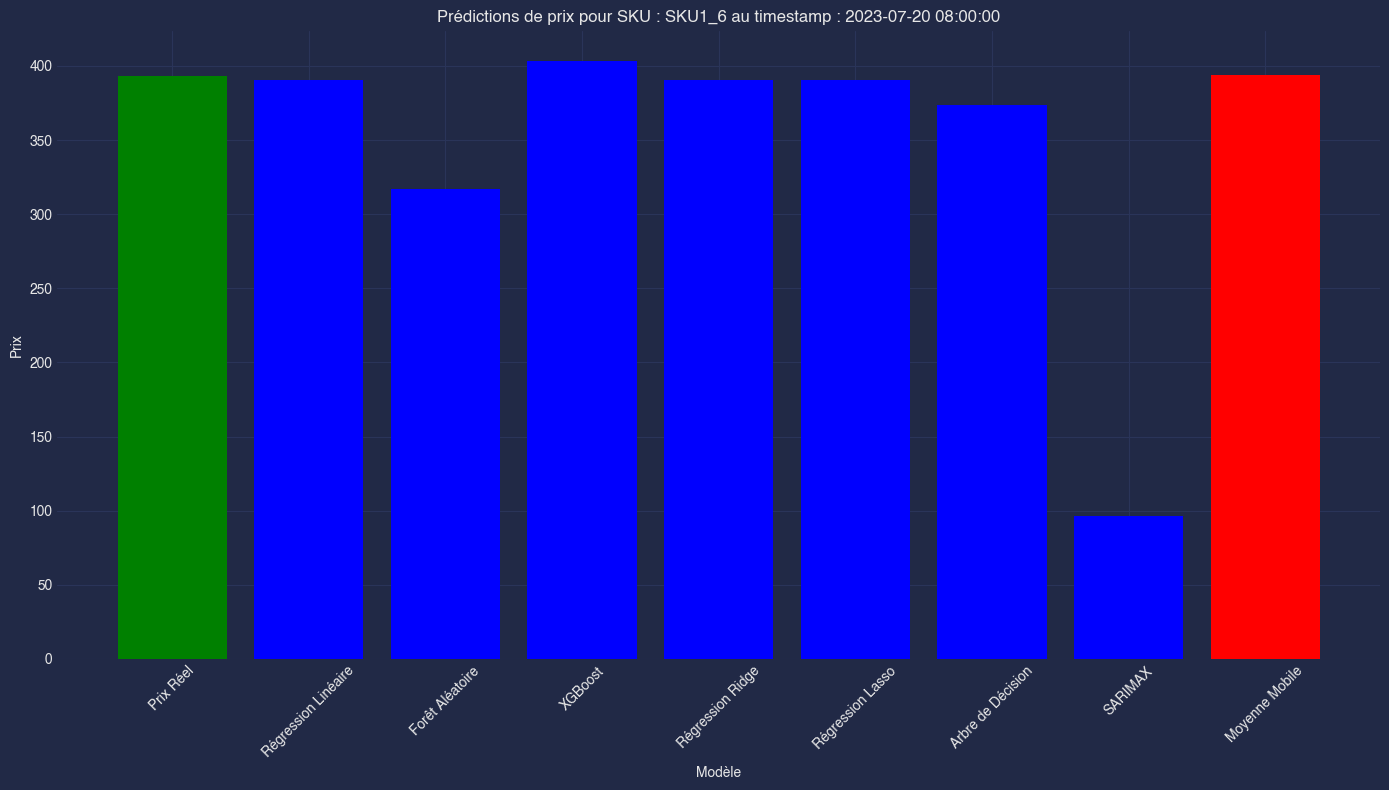

In [13]:

# Calcul de la moyenne mobile
window_size = 9
df_validation_scaled['Moving_Avg'] = df_validation_scaled['Prix'].rolling(window=window_size, min_periods=1).mean()

# Sélection d'une observation aléatoire
random_index = random.randint(0, len(df_validation_scaled) - 1)
random_observation = df_validation_scaled.iloc[random_index]
random_sku = random_observation['SKU']
random_timestamp = random_observation['Timestamp']

# Recherche de l'index
index_random = df_validation_scaled.index[random_index]
y_actual = df_validation_scaled.loc[index_random, 'Prix']

# Moyenne mobile
y_pred_moving_avg = df_validation_scaled.loc[index_random, 'Moving_Avg']

# Préparation des données pour les modèles hors SARIMAX
df_random_reg = df_validation_scaled.loc[[index_random]].copy()

# Suppression des colonnes inutiles
df_random_reg = df_random_reg.drop(columns=['Prix', 'SKU', 'Timestamp', 'Moving_Avg'])

# Alignement des colonnes avec les colonnes utilisées pour l'entraînement
training_columns = df_validation_scaled.drop(columns=['SKU', 'Prix', 'Timestamp', 'Moving_Avg']).columns
missing_cols = set(training_columns) - set(df_random_reg.columns)
for col in missing_cols:
    df_random_reg[col] = 0
df_random_reg = df_random_reg[training_columns]

# Prédictions avec les modèles hors SARIMAX
y_pred_lr = model_lr.predict(df_random_reg)[0]
y_pred_rf = model_rf.predict(df_random_reg)[0]
y_pred_xgb = model_xgb.predict(df_random_reg)[0]
y_pred_ridge = model_ridge.predict(df_random_reg)[0]
y_pred_lasso = model_lasso.predict(df_random_reg)[0]
y_pred_dt = model_dt.predict(df_random_reg)[0]

# Prédictions avec SARIMAX
exog_columns = ['QuantiteVendue', 'UtiliteProduit', 'ElasticitePrix', 'Remise']
exog_validation = df_validation_scaled[exog_columns].iloc[[index_random]]

# Vérification des NaN dans les exogènes
if exog_validation.isnull().any().any():
    raise ValueError("Exogenous variables contain NaN values!")

forecast_sarimax = model_sarimax.get_forecast(steps=1, exog=exog_validation)
y_pred_sarimax = forecast_sarimax.predicted_mean.iloc[0]

# Compilation des résultats
results = pd.DataFrame({
    'Modèle': [
        'Prix Réel',
        'Régression Linéaire',
        'Forêt Aléatoire',
        'XGBoost',
        'Régression Ridge',
        'Régression Lasso',
        'Arbre de Décision',
        'SARIMAX',
        'Moyenne Mobile'
    ],
    'Prix': [
        y_actual,
        y_pred_lr,
        y_pred_rf,
        y_pred_xgb,
        y_pred_ridge,
        y_pred_lasso,
        y_pred_dt,
        y_pred_sarimax,
        y_pred_moving_avg
    ]
})

# Identification du modèle le plus proche
results['Diff'] = abs(results['Prix'] - y_actual)
closest_model_index = results['Diff'][1:].idxmin()
results.drop(columns=['Diff'], inplace=True)

# Affichage des résultats
print(f"\nPrédictions pour le SKU : {random_sku} au timestamp : {random_timestamp}")
print(results)

# Visualisation des résultats
plt.figure(figsize=(14, 8))
colors = ['green' if i == 0 else 'blue' for i in range(len(results))]
colors[closest_model_index] = 'red'

plt.bar(results['Modèle'], results['Prix'], color=colors)
plt.xlabel('Modèle')
plt.ylabel('Prix')
plt.title(f'Prédictions de prix pour SKU : {random_sku} au timestamp : {random_timestamp}')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
